In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
active_directory = '/content/drive/MyDrive/Desktop/DP_Finetuning_Harnet_Submission'
os.chdir(active_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## IMPORT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
import pickle
from warnings import filterwarnings
from pandas.errors import SettingWithCopyWarning

filterwarnings("ignore", category=SettingWithCopyWarning)
filterwarnings('ignore', category=UserWarning)

## READ SUBJECT FILES

Each of the data-files contains 54 columns per row, the columns contain the following data:

-  1 timestamp (s)
- 2 activityID (see II.2. for the mapping to the activities)
- 3 heart rate (bpm)
- 4-20 IMU hand
- 21-37 IMU chest
- 38-54 IMU ankle

The IMU sensory data contains the following columns:

- 1 temperature (°C)
- 2-4 3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit
-  5-7 3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit*
- 8-10 3D-gyroscope data (rad/s)
- 11-13 3D-magnetometer data (μT)
- 14-17 orientation (invalid in this data collection)

16g acceleration hand -> indexes [4, 5, 6]

timestamp -> [0]

activity_id -> [1]

In [ ]:

def read_subject_file(file_path:str)->pd.DataFrame:
    subject_name = file_path.split('/')[-1].rstrip('.dat')
    subject = pd.read_table(file_path, header=None, sep='\s+')
    return subject, subject_name

class DataProcessor:
  def __init__(self, subject_dataframe:pd.DataFrame, subject_name:str):
    self.subject_dataframe = subject_dataframe
    self.subject_name = subject_name
    self.acc_x_col = 'acc_x'
    self.acc_y_col = 'acc_y'
    self.acc_z_col = 'acc_z'
    self.timestamp = 'timestamp'
    self.activity_id = 'activity_id'

  def _extract_data(self)->pd.DataFrame:
    """
    Extract the relevant columns from the data
    """
    # timestamp, activity_id, 16g_acc_x, 16g_acc_y, 16g_acc_z
    raw_data = self.subject_dataframe.iloc[:, [0, 1, 4, 5, 6]]
    raw_data.columns = [self.timestamp , self.activity_id , self.acc_x_col, self.acc_y_col, self.acc_z_col]
    return raw_data

  def _handle_missing_values(self, data:pd.DataFrame)->pd.DataFrame:
    """
    Used linear interpolation for the acceleration data
    """
    data[self.acc_x_col] = data[self.acc_x_col].interpolate(method='linear', limit_direction='both')
    data[self.acc_y_col] = data[self.acc_y_col].interpolate(method='linear', limit_direction='both')
    data[self.acc_z_col] = data[self.acc_z_col].interpolate(method='linear', limit_direction='both')
    return data

  def sorted_timestamps(self, data:pd.DataFrame)->pd.DataFrame:
    """
    Sort the timestamps in ascending order
    """
    data = data.sort_values(by=self.timestamp, ascending=True).reset_index(drop=True)
    return data

  def downsample_from_100_to_30hz(self, data:pd.DataFrame)->pd.DataFrame:
    """
    Downsample the data from 100Hz to 30Hz
    """

    data_copy = data.copy()
    data_copy.set_index(self.timestamp, inplace=True)
    data_copy.index = pd.to_timedelta(data_copy.index, unit="s")
    data_copy = data_copy.resample('0.0333s').agg({self.activity_id: lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
                                        self.acc_x_col:"mean",
                                        self.acc_y_col:"mean",
                                        self.acc_z_col:"mean"}).reset_index()
    return data_copy


def activity_mapping(value:int):
  mapping_dict = {
        0: "other",
        1: "lying",
        2: "sitting",
        3: "standing",
        4: "walking",
        5: "running",
        6: "cycling",
        7: "Nordic walking",
        9: "watching TV",
        10: "computer work",
        11: "car driving",
        12: "ascending stairs",
        13: "descending stairs",
        16: "vacuum cleaning",
        17: "ironing",
        18: "folding laundry",
        19: "house cleaning",
        20: "playing soccer",
        24: "rope jumping"
   }
  return mapping_dict.get(value, 'Unknown')


def create_sliding_windows(dataframe, window_length_sec, sampling_rate_hz, step_duration_sec):
  import scipy.stats as stats


  N_FEATURES = 3
  window_length_samples = int(window_length_sec * sampling_rate_hz)
  step_duration_samples = int(step_duration_sec * sampling_rate_hz)
  windows = []
  labels = []
  for i in range(0, len(dataframe)-window_length_samples, step_duration_samples):
    x = dataframe['acc_x'].values[i: i + window_length_samples]
    y = dataframe['acc_y'].values[i: i + window_length_samples]
    z = dataframe['acc_z'].values[i: i + window_length_samples]
    window = np.array([x, y, z])
    label = dataframe['activity_id'][i: i + window_length_samples]

    windows.append(window)
    labels.append(label)

  windows = np.asarray(windows).reshape(-1, N_FEATURES, window_length_samples, )
  labels = np.asarray(labels)

  return windows, labels



def clean_window_labels(window_X, window_y):
  """
  Remove the windows that have activity id = 0 ratio > 0.5
  """
  clean_window_X = []
  clean_window_y = []

  for i in range(len(window_y)):
    if np.sum(window_y[i] == 0) / len(window_y[i]) < 0.5:
      clean_window_X.append(window_X[i])
      clean_window_y.append(window_y[i])

  clean_window_X = np.array(clean_window_X)
  clean_window_y = np.array(clean_window_y)

  return clean_window_X, clean_window_y


def majority_voting(window_y):
  """
  Most frequent activity id in a window
  """
  from scipy import stats as st

  major_window_y = st.mode(window_y, axis=1).mode
  return major_window_y


def reshaped_windows(window_X, window_y):
  """
  Reshape the windows to fit the model (n_windows, n_features, n_timestamps)
  """
  window_X = window_X.reshape(window_X.shape[0], window_X.shape[2], window_X.shape[1])
  window_y = window_y.reshape(window_y.shape[0], )
  return window_X, window_y


def activity_filter(window_X, window_y):
  """
  Filtering the activities that everybody does. (1, 2, 3, 4, 12, 13, 16, 17)
  """
  filtered_window_X = []
  filtered_window_y = []

  valid_indices = (
            (window_y == 1) | (window_y == 2) | (window_y == 3) | (window_y == 4) | (window_y == 12) | (window_y == 13) | (window_y == 16) | (window_y == 17)
        )

  filtered_window_X = window_X[valid_indices]
  filtered_window_y = window_y[valid_indices]

  return filtered_window_X, filtered_window_y



In [ ]:
file_dir = 'Protocol'
subject_raw_files = os.listdir(file_dir)

In [ ]:
subject_arr_Xs = []
subject_arr_ys = []
subject_names = []

window_length_sec = 10
step_duration_sec = 5
sampling_rate_hz = 30
overlap_ratio = round((100*(window_length_sec-step_duration_sec)/window_length_sec), 2)


print(f'WINDOW LENGTH in SAMPLES: {int(window_length_sec * sampling_rate_hz)}')
print(f'STEP DURATION in SAMPLES: {int(step_duration_sec * sampling_rate_hz)}')
print(f'OVERLAPPING WINDOW RATIO: {overlap_ratio}%')


for f in subject_raw_files:
  file_path = os.path.join(file_dir, f)
  subject, subject_name = read_subject_file(file_path)
  if subject_name != 'subject109':
    print('-----------------------------------------------------------')
    print(f'Data preprocessing is starting for {subject_name}...')
    processor = DataProcessor(subject, subject_name)
    raw_data = processor._extract_data()

    subject_df = processor._handle_missing_values(raw_data)   # Missing axes values are filled by applying linear interpolation
    subject_df = processor.sorted_timestamps(subject_df)    # Update if the timestamps is not ascending
    downsampled_subject_df = processor.downsample_from_100_to_30hz(subject_df)    # Downsample the data from 100Hz to 30Hz

    win_X, win_y = create_sliding_windows(downsampled_subject_df, window_length_sec=window_length_sec, sampling_rate_hz=sampling_rate_hz, step_duration_sec=step_duration_sec)
    clean_win_X, clean_win_y = clean_window_labels(win_X, win_y)    # Remove the windows that have activity id = 0 ratio > 0.5
    major_win_y = majority_voting(clean_win_y)    # Majority voting for the labels in a window
    filtered_window_X, filtered_window_y = activity_filter(clean_win_X, major_win_y)   # Filtering the activities that everybody does. (1, 2, 3, 4, 12, 13, 16, 17)

    print(f'Final remaining shapes X: {filtered_window_X.shape}, y: {filtered_window_y.shape}')

    subject_arr_Xs.append(filtered_window_X)
    subject_arr_ys.append(filtered_window_y)
    subject_names.append(subject_name)


all_subject_infos = list(zip(subject_names, subject_arr_Xs, subject_arr_ys))

WINDOW LENGTH in SAMPLES: 300
STEP DURATION in SAMPLES: 150
OVERLAPPING WINDOW RATIO: 50.0%
-----------------------------------------------------------
Data preprocessing is starting for subject101...
Final remaining shapes X: (345, 3, 300), y: (345,)
-----------------------------------------------------------
Data preprocessing is starting for subject102...
Final remaining shapes X: (373, 3, 300), y: (373,)
-----------------------------------------------------------
Data preprocessing is starting for subject103...
Final remaining shapes X: (348, 3, 300), y: (348,)
-----------------------------------------------------------
Data preprocessing is starting for subject104...
Final remaining shapes X: (364, 3, 300), y: (364,)
-----------------------------------------------------------
Data preprocessing is starting for subject105...
Final remaining shapes X: (379, 3, 300), y: (379,)
-----------------------------------------------------------
Data preprocessing is starting for subject106...

In [ ]:
activity_dfs = []

for sb_n, Xs, ys in all_subject_infos:
  print(f'Subject {sb_n}: {np.unique(ys, return_counts=True)}')

  subject_activities = np.vectorize(activity_mapping)(ys)
  activity_counts = pd.Series(subject_activities).value_counts(normalize=True).reset_index()
  activity_counts.columns = ['Activity', 'Ratio']
  activity_counts['Ratio'] = activity_counts['Ratio'] * 100
  activity_counts['Subject'] = sb_n

  activity_dfs.append(activity_counts)

final_activity_df = pd.concat(activity_dfs, axis=0, ignore_index=True)

Subject subject101: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([55, 47, 43, 45, 33, 29, 46, 47]))
Subject subject102: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([47, 45, 51, 65, 34, 31, 42, 58]))
Subject subject103: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([44, 57, 41, 58, 21, 30, 41, 56]))
Subject subject104: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([47, 51, 50, 64, 33, 29, 40, 50]))
Subject subject105: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([48, 53, 45, 64, 29, 25, 49, 66]))
Subject subject106: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([46, 46, 49, 51, 27, 22, 42, 76]))
Subject subject107: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([51, 25, 51, 67, 36, 22, 43, 60]))
Subject subject108: (array([ 1,  2,  3,  4, 12, 13, 16, 17]), array([48, 46, 50, 63, 23, 19, 49, 66]))


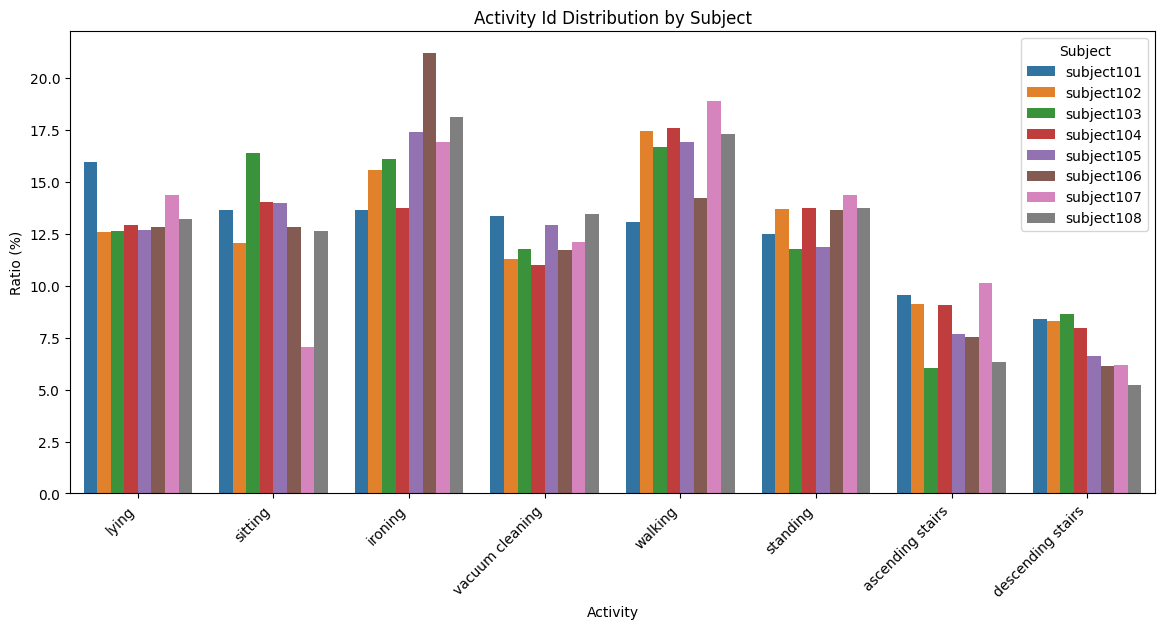

In [ ]:
plt.figure(figsize=(14, 6))
sns.barplot(data=final_activity_df, x='Activity', y='Ratio', hue='Subject')
plt.xlabel('Activity')
plt.ylabel('Ratio (%)')
plt.title('Activity Id Distribution by Subject')
plt.xticks(rotation=45, ha='right')
plt.show();

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

def get_pretrained_harnet(class_num, model_name = 'harnet10'):
    repo = 'OxWearables/ssl-wearables'
    model = torch.hub.load(repo, model_name, class_num=class_num, pretrained=True, force_reload=True)
    return model

def train(model, train_loader, optimizer, criterion, epoch, device, is_dp=False, privacy_engine=None, delta=None):
  model.train()
  total_loss = 0
  correct = 0
  total_samples = 0
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * data.size(0)
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
      total_samples += data.size(0)
      if batch_idx % 10 == 0:
          if is_dp and privacy_engine:
              epsilon = privacy_engine.get_epsilon(delta)
              print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                    f"({100. * batch_idx / len(train_loader):.0f}%)]\t"
                    f"Loss: {loss.item():.6f}\tEpsilon: {epsilon:.2f}")
          else:
              print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                    f"({100. * batch_idx / len(train_loader):.0f}%)]\t"
                    f"Loss: {loss.item():.6f}")

  avg_loss = total_loss / total_samples
  accuracy = 100. * correct / total_samples
  print(f"Epoch {epoch} - Training: Average loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
  return avg_loss, accuracy


def evaluate(model, test_loader, criterion, device):
  model.eval()
  test_loss = 0
  correct = 0
  all_preds = []
  all_targets = []
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += criterion(output, target).item() * data.size(0)
          pred = output.argmax(dim=1, keepdim=True)
          correct += pred.eq(target.view_as(pred)).sum().item()
          all_preds.extend(pred.cpu().numpy())
          all_targets.extend(target.cpu().numpy())
  test_loss /= len(test_loader.dataset)
  accuracy = 100. * correct / len(test_loader.dataset)
  f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
  print(f"Evaluation set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} "
        f"({accuracy:.2f}%), F1-score: {f1:.4f}\n")
  return test_loss, accuracy, f1


class CustomScaler:
  """
  A wrapper for scikit-learn's StandardScaler that handles both 2D and 3D NumPy arrays.
  For 3D data, it reshapes to 2D, scales, and then reshapes back.
  """
  def __init__(self):
      self._scaler = StandardScaler()
      self._is_fitted = False
      self._original_input_dims = None
  def fit(self, data: np.ndarray):
      self._original_input_dims = data.ndim
      if self._original_input_dims == 2:
          self._scaler.fit(data)
      elif self._original_input_dims == 3:
          n_samples, n_timesteps, n_features = data.shape
          reshaped_data = data.reshape((n_samples * n_timesteps, n_features))
          self._scaler.fit(reshaped_data)
      else:
          raise ValueError("Input data must have 2 or 3 dimensions for scaling.")
      self._is_fitted = True
      return self
  def fit_transform(self, data: np.ndarray) -> np.ndarray:
      self._original_input_dims = data.ndim

      if self._original_input_dims == 2:
          scaled_data = self._scaler.fit_transform(data)
      elif self._original_input_dims == 3:
          n_samples, n_timesteps, n_features = data.shape
          # Reshape 3D data to 2D for scaling
          reshaped_data = data.reshape((n_samples * n_timesteps, n_features))
          scaled_reshaped_data = self._scaler.fit_transform(reshaped_data)
          # Reshape scaled data back to original 3D shape
          scaled_data = scaled_reshaped_data.reshape((n_samples, n_timesteps, n_features))
      else:
          raise ValueError("Input data must have 2 or 3 dimensions for scaling.")

      self._is_fitted = True
      return scaled_data

  def transform(self, data: np.ndarray) -> np.ndarray:
    if not self._is_fitted:
      raise RuntimeError("Scaler has not been fitted. Call fit_transform first.")
    if data.ndim != self._original_input_dims:
      raise ValueError(f"Input data has {data.ndim} dimensions, but scaler was fitted on "
                            f"data with {self._original_input_dims} dimensions.")
    if self._original_input_dims == 2:
        scaled_data = self._scaler.transform(data)
    elif self._original_input_dims == 3:
        n_samples, n_timesteps, n_features = data.shape
        reshaped_data = data.reshape((n_samples * n_timesteps, n_features))
        scaled_reshaped_data = self._scaler.transform(reshaped_data)
        scaled_data = scaled_reshaped_data.reshape((n_samples, n_timesteps, n_features))
    else:
        raise ValueError("Input data must have 2 or 3 dimensions.")

    return scaled_data

def get_data_loader(X_test, y_test, BATCH_SIZE, shuffle=False):
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.long)
  test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=shuffle)
  return test_loader

class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False):
      self.patience = patience
      self.delta = delta
      self.best_score = None
      self.early_stop = False
      self.counter = 0
      self.best_model_state = None
      self.verbose = verbose
      self.best_epoch = 0
  def __call__(self, val_loss, model, epoch):
      score = -val_loss
      if self.best_score is None:
          self.best_score = score
          self.best_model_state = copy.deepcopy(model.state_dict())
          self.best_epoch = epoch
      elif score < self.best_score + self.delta:
          self.counter += 1
          if self.verbose:
              print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
          if self.counter >= self.patience:
              self.early_stop = True
      else:
          self.best_score = score
          self.best_model_state = copy.deepcopy(model.state_dict())
          self.best_epoch = epoch
          self.counter = 0

  def load_best_model(self, model):
      if self.best_model_state:
          model.load_state_dict(self.best_model_state)



def plot_distribution(arr:np.ndarray, title:str):
  pd.Series(arr).value_counts(normalize=True).plot(kind='bar')
  plt.title(title)
  plt.show()


In [ ]:
def fold_plot(fold_train_accuracies, fold_val_accuracies, val_subjects):
  import matplotlib.pyplot as plt
  import math
  # Get the list of train and val accuracies
  acc_list_zipped = list(zip(fold_train_accuracies, fold_val_accuracies, val_subjects))

  # Get the total number of folds to plot
  num_folds = len(acc_list_zipped)

  # --- Subplot Layout Calculation ---
  ncols = 2
  nrows = math.ceil(num_folds / ncols)

  # --- Create the Figure and Subplots ---
  fig, axes = plt.subplots(nrows, ncols, figsize=(14, 5 * nrows))
  fig.suptitle('Training vs. Validation Accuracy Across Folds', fontsize=16, y=1.02)
  axes = axes.flatten()


  # --- Loop and Plot on Each Subplot ---
  for i, (tr_acc, vl_acc, vl_subjects) in enumerate(acc_list_zipped):
      ax = axes[i] # Get the current axis
      ax.plot(tr_acc, label='Train Accuracy', color='royalblue')
      ax.plot(vl_acc, label='Validation Accuracy', color='darkorange')
      ax.set_title(f'Fold: {i + 1} for  Validation Subjects {vl_subjects}')
      ax.set_xlabel('Epoch')
      ax.set_ylabel('Accuracy')
      ax.legend()
      ax.grid(True, linestyle='--', alpha=0.6)

  # --- Clean Up and Display ---
  # If the number of folds is odd, the last subplot in the grid will be empty.
  # This loop hides any unused subplots.
  for i in range(num_folds, len(axes)):
      axes[i].axis('off')

  # Adjusts subplot params so that subplots are nicely fit in the figure.
  fig.tight_layout(rect=[0, 0, 1, 0.98])

  return fig


def plot_epochs(train_accs, val_accs, val_subj):
  import matplotlib.pyplot as plt
  epochs = np.arange(1, len(train_accs) + 1)
  fig, ax = plt.subplots()
  ax.plot(epochs, train_accs, label='Train Accuracy', color='royalblue')
  ax.plot(epochs, val_accs, label='Validation Accuracy', color='darkorange')
  ax.set_title(f'Training vs. Validation Accuracy for Validation Subjects {val_subj}')
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy')
  ax.set_xticks(epochs)
  ax.legend()
  ax.grid(True, linestyle='--', alpha=0.6)
  return fig

## FINE TUNING of CLASSIFIER HEADS

In [ ]:
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold, LeaveOneGroupOut
import torch.nn as nn
import copy
from itertools import product

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

label_encoder = LabelEncoder()

reports_save = True

X_combined = []
y_combined = []
subject_groups_combined = []

for sb_name, Xs, ys in all_subject_infos:
  X_combined.extend(Xs)
  y_combined.extend(ys)
  subject_groups_combined.extend([sb_name] * len(ys))

X_combined = np.array(X_combined)
y_combined = np.array(y_combined)
subject_groups_combined = np.array(subject_groups_combined)

label_encoder.fit(y_combined)
encoded_y_combined_raw = label_encoder.transform(y_combined)

# Considering acitivities distribution
outer_skf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)


EPOCHS = 20
BATCH_SIZE_LIST = [32]
LRATE_LIST = [1e-3]

parameter_pairs = list(product(BATCH_SIZE_LIST, LRATE_LIST))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_CLASSES = len(label_encoder.classes_)


for BATCH_SIZE, LRATE in parameter_pairs:
  print('-------------------------------------------------------------------------------------------------')
  print(f'Batch size: {BATCH_SIZE}, Learning rate: {LRATE}')
  print('-------------------------------------------------------------------------------------------------')

  test_outer_subject_list = []
  test_outer_losses = []
  test_outer_accuracies = []
  test_outer_f1s = []
  best_fold_train_losses = []
  best_fold_val_losses = []
  best_fold_val_f1s = []
  best_fold_train_accuracies = []
  best_fold_val_accuracies = []
  best_fold_epochs = []
  l_rates = []
  batch_sizes = []
  fold_details = {"Test Subjects": [], "Batch_Size": BATCH_SIZE, "Learning_Rate": LRATE, "Epoch_Results": []}
  for outer_fold, (train_outer_index, test_outer_index) in enumerate(outer_skf.split(X_combined, encoded_y_combined_raw, subject_groups_combined), start=1):
    print(f'Outer Fold {outer_fold} is starting ...')
    X_outer_train_val, X_outer_test = X_combined[train_outer_index], X_combined[test_outer_index]
    y_outer_train_val, y_outer_test = encoded_y_combined_raw[train_outer_index], encoded_y_combined_raw[test_outer_index]

    train_val_subject_groups = subject_groups_combined[train_outer_index]

    test_outer_subjects = np.unique(subject_groups_combined[test_outer_index] )
    train_outer_subjects = np.unique(train_val_subject_groups)

    print(f'Test subjects: {test_outer_subjects}')
    print(f'Train-Validation subjects: {train_outer_subjects}')

    # Leave One Group Out for inner fold
    inner_skf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

    fold_val_subjects = []
    fold_train_subjects = []
    fold_train_losses = []
    fold_val_losses = []
    fold_train_accuracies = []
    fold_val_accuracies = []
    fold_epochs = []
    fold_best_epochs = []
    fold_f1_scores = []

    for fold, (train_index, val_index) in enumerate(inner_skf.split(X_outer_train_val, y_outer_train_val, train_val_subject_groups), start=1):
      print(f'Fold {fold} is starting ...')

      X_train, X_val = X_outer_train_val[train_index], X_outer_train_val[val_index]
      y_train, y_val = y_outer_train_val[train_index], y_outer_train_val[val_index]

      val_subjects = np.unique(train_val_subject_groups[val_index])
      train_subjects = np.unique(train_val_subject_groups[train_index])
      print(f'Validation subjects : {val_subjects}')
      print(f'Train subjects: {train_subjects}')

      scaler = CustomScaler()
      scaled_X_train = scaler.fit_transform(X_train)
      scaled_X_val = scaler.transform(X_val)

      train_data_loader = get_data_loader(scaled_X_train, y_train, BATCH_SIZE=BATCH_SIZE, shuffle=True)
      val_data_loader = get_data_loader(scaled_X_val, y_val, BATCH_SIZE=BATCH_SIZE, shuffle=False)

      model = get_pretrained_harnet(class_num=N_CLASSES, model_name='harnet10')
      model.to(device)

      for name, param in model.named_parameters():
        if name.startswith('classifier'):
          param.requires_grad = True
        else:
          param.requires_grad = False

      optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LRATE, weight_decay=0.01)
      criterion = nn.CrossEntropyLoss()
      early_stopping = EarlyStopping(patience=10, verbose=True)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

      val_losses = []
      val_accuracies = []
      val_f1s = []
      train_losses = []
      train_accuracies = []
      epochs_list = []

      epoch_results = {"epoch": [], "val_subjects":val_subjects, "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_f1": []}
      best_val_loss = float('inf')
      best_model_state = None
      best_scaler = None
      best_epoch = None
      for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train(model, train_data_loader, optimizer, criterion, epoch, device)
        val_loss, val_acc, val_f1 = evaluate(model, val_data_loader, criterion, device)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)
        epochs_list.append(epoch)

        epoch_results["epoch"].append(epoch)
        epoch_results["train_loss"].append(train_loss)
        epoch_results["train_acc"].append(train_acc)
        epoch_results["val_loss"].append(val_loss)
        epoch_results["val_acc"].append(val_acc)
        epoch_results["val_f1"].append(val_f1)

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_model_state = copy.deepcopy(model.state_dict())
          best_epoch = epoch
          best_scaler = copy.deepcopy(scaler)

        early_stopping(val_loss, model, epoch)
        if early_stopping.early_stop:
          print("Early stopping")
          break

      # Scores are added based on the best epoch considering early stopping to prevent overfitting
      best_epoch_index = best_epoch - 1   # Since epoch loop starts with 1

      # TEST SUBJECTS EVALUATION
      print(f' #### Test Evaluation is starting for {test_outer_subjects} #### ')
      final_val_model = get_pretrained_harnet(class_num=N_CLASSES, model_name='harnet10')
      final_val_model.load_state_dict(best_model_state)
      final_val_model.to(device)

      scaled_X_outer_test = best_scaler.transform(X_outer_test)
      test_data_loader = get_data_loader(scaled_X_outer_test, y_outer_test, BATCH_SIZE=BATCH_SIZE, shuffle=False)
      test_loss, test_acc, test_f1 = evaluate(final_val_model, test_data_loader, criterion, device)

      test_outer_subject_list.append(test_outer_subjects)
      test_outer_losses.append(test_loss)
      test_outer_accuracies.append(test_acc)
      test_outer_f1s.append(test_f1)
      best_fold_train_losses.append(train_losses[best_epoch_index])
      best_fold_val_losses.append(val_losses[best_epoch_index])
      best_fold_val_f1s.append(val_f1s[best_epoch_index])
      best_fold_train_accuracies.append(train_accuracies[best_epoch_index])
      best_fold_val_accuracies.append(val_accuracies[best_epoch_index])
      best_fold_epochs.append(epochs_list[best_epoch_index])
      fold_train_subjects.append(train_subjects)
      fold_val_subjects.append(val_subjects)
      fold_details['Test Subjects'].append(test_outer_subjects)
      fold_details['Epoch_Results'].append(epoch_results)
      batch_sizes.append(BATCH_SIZE)
      l_rates.append(LRATE)


directory_name = 'downsampled_results_noDP'
os.makedirs(directory_name, exist_ok=True)


today_time = dt.date.today().strftime("%Y%m%d")
vers = f'{window_length_sec}_{sampling_rate_hz}_{overlap_ratio}_{today_time}'

fold_details_df = pd.DataFrame(fold_details)

summary_df = pd.DataFrame({'Test_Subjects':test_outer_subject_list,
                           "Test_Losses":test_outer_losses,
                           "Best_Val_Losses":best_fold_val_losses,
                           "Best_Train_Losses":best_fold_train_losses,
                           "Test_Accuracies":test_outer_accuracies,
                           "Best_Val_Accuracies":best_fold_val_accuracies,
                           "Best_Train_Accuracies":best_fold_train_accuracies,
                           "Test_F1s":test_outer_f1s,
                           "Best_Val_F1s":best_fold_val_f1s,
                           "Best_Val_Epochs":best_fold_epochs,
                           "Batch_Size":batch_sizes,
                           "Learning_Rate":l_rates
                           })

if reports_save:
  fold_details_df.to_csv(f'{directory_name}/fold_details_noDP_CH_{vers}_Split_4-2-2.csv')
  summary_df.to_csv(f'{directory_name}/summary_df_noDP_CH_{vers}_Split_4-2-2.csv')


-------------------------------------------------------------------------------------------------
Batch size: 32, Learning rate: 0.001
-------------------------------------------------------------------------------------------------
Outer Fold 1 is starting ...
Test subjects: ['subject102' 'subject107']
Train-Validation subjects: ['subject101' 'subject103' 'subject104' 'subject105' 'subject106'
 'subject108']
Fold 1 is starting ...
Validation subjects : ['subject104' 'subject105']
Train subjects: ['subject101' 'subject103' 'subject106' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1416 (0%)]	Loss: 8.496016
Train Epoch: 1 [320/1416 (22%)]	Loss: 2.095645
Train Epoch: 1 [640/1416 (44%)]	Loss: 1.455603
Train Epoch: 1 [960/1416 (67%)]	Loss: 1.723936
Train Epoch: 1 [1280/1416 (89%)]	Loss: 1.363698
Epoch 1 - Training: Average loss: 2.6291, Accuracy: 63.28%
Evaluation set: Average loss: 2.6807, Accuracy: 510/743 (68.64%), F1-score: 0.6668

Train Epoch: 2 [0/1416 (0%)]	Loss: 0.820074
Train Epoch: 2 [320/1416 (22%)]	Loss: 0.778991
Train Epoch: 2 [640/1416 (44%)]	Loss: 1.034939
Train Epoch: 2 [960/1416 (67%)]	Loss: 0.508843
Train Epoch: 2 [1280/1416 (89%)]	Loss: 1.361179
Epoch 2 - Training: Average loss: 1.2553, Accuracy: 77.82%
Evaluation set: Average loss: 2.6697, Accuracy: 497/743 (66.89%), F1-score: 0.6402

Train Epoch: 3 [0/1416 (0%)]	Loss: 0.989392
Train Epoch: 3 [320/1416 (22%)]	Loss: 1.180973
Train Epoch: 3 [640/1416 (44%)]	Loss: 1.027350
Train Epoch: 3 [960/1416 (67%)]	Loss: 0.932795
Train Epoch: 3 [1280/1416 (89%)]	Loss: 1.376

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.9184, Accuracy: 535/728 (73.49%), F1-score: 0.7021

Fold 2 is starting ...
Validation subjects : ['subject103' 'subject106']
Train subjects: ['subject101' 'subject104' 'subject105' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1452 (0%)]	Loss: 8.554526
Train Epoch: 1 [320/1452 (22%)]	Loss: 6.525715
Train Epoch: 1 [640/1452 (43%)]	Loss: 1.241898
Train Epoch: 1 [960/1452 (65%)]	Loss: 1.558494
Train Epoch: 1 [1280/1452 (87%)]	Loss: 2.827818
Epoch 1 - Training: Average loss: 2.6983, Accuracy: 63.09%
Evaluation set: Average loss: 2.5778, Accuracy: 471/707 (66.62%), F1-score: 0.5913

Train Epoch: 2 [0/1452 (0%)]	Loss: 0.895007
Train Epoch: 2 [320/1452 (22%)]	Loss: 1.965458
Train Epoch: 2 [640/1452 (43%)]	Loss: 0.997422
Train Epoch: 2 [960/1452 (65%)]	Loss: 0.591546
Train Epoch: 2 [1280/1452 (87%)]	Loss: 0.328761
Epoch 2 - Training: Average loss: 1.4478, Accuracy: 75.55%
Evaluation set: Average loss: 1.8488, Accuracy: 499/707 (70.58%), F1-score: 0.6557

Train Epoch: 3 [0/1452 (0%)]	Loss: 0.714496
Train Epoch: 3 [320/1452 (22%)]	Loss: 1.190804
Train Epoch: 3 [640/1452 (43%)]	Loss: 0.776823
Train Epoch: 3 [960/1452 (65%)]	Loss: 0.626753
Train Epoch: 3 [1280/1452 (87%)]	Loss: 0.402

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.4615, Accuracy: 532/728 (73.08%), F1-score: 0.6941

Fold 3 is starting ...
Validation subjects : ['subject101' 'subject108']
Train subjects: ['subject103' 'subject104' 'subject105' 'subject106']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1450 (0%)]	Loss: 8.922926
Train Epoch: 1 [320/1450 (22%)]	Loss: 4.013504
Train Epoch: 1 [640/1450 (43%)]	Loss: 2.038270
Train Epoch: 1 [960/1450 (65%)]	Loss: 1.177982
Train Epoch: 1 [1280/1450 (87%)]	Loss: 1.698244
Epoch 1 - Training: Average loss: 3.1520, Accuracy: 62.55%
Evaluation set: Average loss: 3.5469, Accuracy: 433/709 (61.07%), F1-score: 0.5617

Train Epoch: 2 [0/1450 (0%)]	Loss: 0.653442
Train Epoch: 2 [320/1450 (22%)]	Loss: 3.101954
Train Epoch: 2 [640/1450 (43%)]	Loss: 1.431128
Train Epoch: 2 [960/1450 (65%)]	Loss: 1.222855
Train Epoch: 2 [1280/1450 (87%)]	Loss: 2.219790
Epoch 2 - Training: Average loss: 1.2228, Accuracy: 77.66%
Evaluation set: Average loss: 2.4834, Accuracy: 483/709 (68.12%), F1-score: 0.6414

Train Epoch: 3 [0/1450 (0%)]	Loss: 0.539017
Train Epoch: 3 [320/1450 (22%)]	Loss: 1.175945
Train Epoch: 3 [640/1450 (43%)]	Loss: 0.525580
Train Epoch: 3 [960/1450 (65%)]	Loss: 2.241511
Train Epoch: 3 [1280/1450 (87%)]	Loss: 0.628

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.3368, Accuracy: 550/728 (75.55%), F1-score: 0.7182

Outer Fold 2 is starting ...
Test subjects: ['subject105' 'subject108']
Train-Validation subjects: ['subject101' 'subject102' 'subject103' 'subject104' 'subject106'
 'subject107']
Fold 1 is starting ...
Validation subjects : ['subject106' 'subject107']
Train subjects: ['subject101' 'subject102' 'subject103' 'subject104']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1430 (0%)]	Loss: 9.063879
Train Epoch: 1 [320/1430 (22%)]	Loss: 3.380301
Train Epoch: 1 [640/1430 (44%)]	Loss: 2.115150
Train Epoch: 1 [960/1430 (67%)]	Loss: 1.909190
Train Epoch: 1 [1280/1430 (89%)]	Loss: 2.650658
Epoch 1 - Training: Average loss: 2.8307, Accuracy: 64.20%
Evaluation set: Average loss: 3.7207, Accuracy: 435/714 (60.92%), F1-score: 0.5563

Train Epoch: 2 [0/1430 (0%)]	Loss: 1.548902
Train Epoch: 2 [320/1430 (22%)]	Loss: 0.972091
Train Epoch: 2 [640/1430 (44%)]	Loss: 1.302300
Train Epoch: 2 [960/1430 (67%)]	Loss: 1.603667
Train Epoch: 2 [1280/1430 (89%)]	Loss: 0.548489
Epoch 2 - Training: Average loss: 1.3304, Accuracy: 76.85%
Evaluation set: Average loss: 2.8253, Accuracy: 466/714 (65.27%), F1-score: 0.5968

Train Epoch: 3 [0/1430 (0%)]	Loss: 0.968794
Train Epoch: 3 [320/1430 (22%)]	Loss: 0.306976
Train Epoch: 3 [640/1430 (44%)]	Loss: 1.465503
Train Epoch: 3 [960/1430 (67%)]	Loss: 0.616680
Train Epoch: 3 [1280/1430 (89%)]	Loss: 0.726

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.8449, Accuracy: 492/743 (66.22%), F1-score: 0.6479

Fold 2 is starting ...
Validation subjects : ['subject101' 'subject103']
Train subjects: ['subject102' 'subject104' 'subject106' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1451 (0%)]	Loss: 8.895071
Train Epoch: 1 [320/1451 (22%)]	Loss: 3.109604
Train Epoch: 1 [640/1451 (43%)]	Loss: 1.668033
Train Epoch: 1 [960/1451 (65%)]	Loss: 1.023280
Train Epoch: 1 [1280/1451 (87%)]	Loss: 3.793391
Epoch 1 - Training: Average loss: 2.6946, Accuracy: 65.47%
Evaluation set: Average loss: 2.2279, Accuracy: 488/693 (70.42%), F1-score: 0.6652

Train Epoch: 2 [0/1451 (0%)]	Loss: 1.180264
Train Epoch: 2 [320/1451 (22%)]	Loss: 0.461045
Train Epoch: 2 [640/1451 (43%)]	Loss: 1.881478
Train Epoch: 2 [960/1451 (65%)]	Loss: 1.499332
Train Epoch: 2 [1280/1451 (87%)]	Loss: 0.404822
Epoch 2 - Training: Average loss: 1.2278, Accuracy: 79.19%
Evaluation set: Average loss: 2.3191, Accuracy: 496/693 (71.57%), F1-score: 0.6832

EarlyStopping counter: 1 out of 10
Train Epoch: 3 [0/1451 (0%)]	Loss: 0.715816
Train Epoch: 3 [320/1451 (22%)]	Loss: 0.843688
Train Epoch: 3 [640/1451 (43%)]	Loss: 1.675644
Train Epoch: 3 [960/1451 (65%)]	Loss: 1.008650
Train Epo

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.4324, Accuracy: 541/743 (72.81%), F1-score: 0.7206

Fold 3 is starting ...
Validation subjects : ['subject102' 'subject104']
Train subjects: ['subject101' 'subject103' 'subject106' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1407 (0%)]	Loss: 10.611506
Train Epoch: 1 [320/1407 (23%)]	Loss: 3.535370
Train Epoch: 1 [640/1407 (45%)]	Loss: 2.632059
Train Epoch: 1 [960/1407 (68%)]	Loss: 0.669757
Train Epoch: 1 [1280/1407 (91%)]	Loss: 1.096784
Epoch 1 - Training: Average loss: 3.1193, Accuracy: 64.53%
Evaluation set: Average loss: 1.8753, Accuracy: 518/737 (70.28%), F1-score: 0.6682

Train Epoch: 2 [0/1407 (0%)]	Loss: 2.094798
Train Epoch: 2 [320/1407 (23%)]	Loss: 0.863782
Train Epoch: 2 [640/1407 (45%)]	Loss: 1.604012
Train Epoch: 2 [960/1407 (68%)]	Loss: 0.313738
Train Epoch: 2 [1280/1407 (91%)]	Loss: 1.023132
Epoch 2 - Training: Average loss: 1.0619, Accuracy: 78.25%
Evaluation set: Average loss: 2.9737, Accuracy: 436/737 (59.16%), F1-score: 0.5949

EarlyStopping counter: 1 out of 10
Train Epoch: 3 [0/1407 (0%)]	Loss: 0.220882
Train Epoch: 3 [320/1407 (23%)]	Loss: 0.555603
Train Epoch: 3 [640/1407 (45%)]	Loss: 0.995439
Train Epoch: 3 [960/1407 (68%)]	Loss: 1.337582
Train Ep

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.3483, Accuracy: 534/743 (71.87%), F1-score: 0.7089

Outer Fold 3 is starting ...
Test subjects: ['subject103' 'subject106']
Train-Validation subjects: ['subject101' 'subject102' 'subject104' 'subject105' 'subject107'
 'subject108']
Fold 1 is starting ...
Validation subjects : ['subject104' 'subject105']
Train subjects: ['subject101' 'subject102' 'subject107' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1437 (0%)]	Loss: 11.561488
Train Epoch: 1 [320/1437 (22%)]	Loss: 4.784612
Train Epoch: 1 [640/1437 (44%)]	Loss: 2.040212
Train Epoch: 1 [960/1437 (67%)]	Loss: 1.189792
Train Epoch: 1 [1280/1437 (89%)]	Loss: 1.798964
Epoch 1 - Training: Average loss: 2.9240, Accuracy: 64.86%
Evaluation set: Average loss: 1.7088, Accuracy: 518/743 (69.72%), F1-score: 0.6743

Train Epoch: 2 [0/1437 (0%)]	Loss: 1.223281
Train Epoch: 2 [320/1437 (22%)]	Loss: 0.603348
Train Epoch: 2 [640/1437 (44%)]	Loss: 1.117731
Train Epoch: 2 [960/1437 (67%)]	Loss: 1.091552
Train Epoch: 2 [1280/1437 (89%)]	Loss: 0.752338
Epoch 2 - Training: Average loss: 1.0583, Accuracy: 77.73%
Evaluation set: Average loss: 1.7687, Accuracy: 498/743 (67.03%), F1-score: 0.6502

EarlyStopping counter: 1 out of 10
Train Epoch: 3 [0/1437 (0%)]	Loss: 0.533880
Train Epoch: 3 [320/1437 (22%)]	Loss: 1.562343
Train Epoch: 3 [640/1437 (44%)]	Loss: 0.474199
Train Epoch: 3 [960/1437 (67%)]	Loss: 1.073603
Train Ep

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 0.9394, Accuracy: 537/707 (75.95%), F1-score: 0.7409

Fold 2 is starting ...
Validation subjects : ['subject102' 'subject107']
Train subjects: ['subject101' 'subject104' 'subject105' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1452 (0%)]	Loss: 9.780472
Train Epoch: 1 [320/1452 (22%)]	Loss: 4.530900
Train Epoch: 1 [640/1452 (43%)]	Loss: 1.530529
Train Epoch: 1 [960/1452 (65%)]	Loss: 3.217066
Train Epoch: 1 [1280/1452 (87%)]	Loss: 0.583377
Epoch 1 - Training: Average loss: 2.9951, Accuracy: 61.98%
Evaluation set: Average loss: 2.1351, Accuracy: 490/728 (67.31%), F1-score: 0.6386

Train Epoch: 2 [0/1452 (0%)]	Loss: 1.435491
Train Epoch: 2 [320/1452 (22%)]	Loss: 1.598047
Train Epoch: 2 [640/1452 (43%)]	Loss: 1.145631
Train Epoch: 2 [960/1452 (65%)]	Loss: 0.723236
Train Epoch: 2 [1280/1452 (87%)]	Loss: 0.970857
Epoch 2 - Training: Average loss: 1.1212, Accuracy: 76.38%
Evaluation set: Average loss: 2.0990, Accuracy: 492/728 (67.58%), F1-score: 0.6538

Train Epoch: 3 [0/1452 (0%)]	Loss: 1.221338
Train Epoch: 3 [320/1452 (22%)]	Loss: 0.709372
Train Epoch: 3 [640/1452 (43%)]	Loss: 0.412082
Train Epoch: 3 [960/1452 (65%)]	Loss: 0.727548
Train Epoch: 3 [1280/1452 (87%)]	Loss: 0.327

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.0983, Accuracy: 530/707 (74.96%), F1-score: 0.6961

Fold 3 is starting ...
Validation subjects : ['subject101' 'subject108']
Train subjects: ['subject102' 'subject104' 'subject105' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1471 (0%)]	Loss: 12.182754
Train Epoch: 1 [320/1471 (22%)]	Loss: 3.918232
Train Epoch: 1 [640/1471 (43%)]	Loss: 2.048092
Train Epoch: 1 [960/1471 (65%)]	Loss: 1.191734
Train Epoch: 1 [1280/1471 (87%)]	Loss: 1.096099
Epoch 1 - Training: Average loss: 2.9298, Accuracy: 65.19%
Evaluation set: Average loss: 2.1728, Accuracy: 469/709 (66.15%), F1-score: 0.6321

Train Epoch: 2 [0/1471 (0%)]	Loss: 2.080451
Train Epoch: 2 [320/1471 (22%)]	Loss: 0.315235
Train Epoch: 2 [640/1471 (43%)]	Loss: 0.934126
Train Epoch: 2 [960/1471 (65%)]	Loss: 1.166989
Train Epoch: 2 [1280/1471 (87%)]	Loss: 0.716248
Epoch 2 - Training: Average loss: 1.0626, Accuracy: 79.67%
Evaluation set: Average loss: 2.0589, Accuracy: 487/709 (68.69%), F1-score: 0.6594

Train Epoch: 3 [0/1471 (0%)]	Loss: 1.121234
Train Epoch: 3 [320/1471 (22%)]	Loss: 0.641928
Train Epoch: 3 [640/1471 (43%)]	Loss: 1.054035
Train Epoch: 3 [960/1471 (65%)]	Loss: 0.749814
Train Epoch: 3 [1280/1471 (87%)]	Loss: 0.76

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.1630, Accuracy: 545/707 (77.09%), F1-score: 0.7404

Outer Fold 4 is starting ...
Test subjects: ['subject101' 'subject104']
Train-Validation subjects: ['subject102' 'subject103' 'subject105' 'subject106' 'subject107'
 'subject108']
Fold 1 is starting ...
Validation subjects : ['subject102' 'subject105']
Train subjects: ['subject103' 'subject106' 'subject107' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1426 (0%)]	Loss: 10.267676
Train Epoch: 1 [320/1426 (22%)]	Loss: 3.458119
Train Epoch: 1 [640/1426 (44%)]	Loss: 1.315441
Train Epoch: 1 [960/1426 (67%)]	Loss: 1.021492
Train Epoch: 1 [1280/1426 (89%)]	Loss: 3.410950
Epoch 1 - Training: Average loss: 2.6812, Accuracy: 66.55%
Evaluation set: Average loss: 3.5135, Accuracy: 475/752 (63.16%), F1-score: 0.6095

Train Epoch: 2 [0/1426 (0%)]	Loss: 3.345560
Train Epoch: 2 [320/1426 (22%)]	Loss: 2.165457
Train Epoch: 2 [640/1426 (44%)]	Loss: 0.855566
Train Epoch: 2 [960/1426 (67%)]	Loss: 1.092896
Train Epoch: 2 [1280/1426 (89%)]	Loss: 0.324877
Epoch 2 - Training: Average loss: 1.1911, Accuracy: 79.59%
Evaluation set: Average loss: 2.4397, Accuracy: 520/752 (69.15%), F1-score: 0.6589

Train Epoch: 3 [0/1426 (0%)]	Loss: 0.888121
Train Epoch: 3 [320/1426 (22%)]	Loss: 0.718034
Train Epoch: 3 [640/1426 (44%)]	Loss: 0.562602
Train Epoch: 3 [960/1426 (67%)]	Loss: 0.662093
Train Epoch: 3 [1280/1426 (89%)]	Loss: 1.01

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 2.0997, Accuracy: 519/709 (73.20%), F1-score: 0.7007

Fold 2 is starting ...
Validation subjects : ['subject103' 'subject108']
Train subjects: ['subject102' 'subject105' 'subject106' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1466 (0%)]	Loss: 8.229247
Train Epoch: 1 [320/1466 (22%)]	Loss: 3.530980
Train Epoch: 1 [640/1466 (43%)]	Loss: 2.495651
Train Epoch: 1 [960/1466 (65%)]	Loss: 1.984802
Train Epoch: 1 [1280/1466 (87%)]	Loss: 0.753270
Epoch 1 - Training: Average loss: 3.2188, Accuracy: 63.03%
Evaluation set: Average loss: 2.0977, Accuracy: 489/712 (68.68%), F1-score: 0.6675

Train Epoch: 2 [0/1466 (0%)]	Loss: 0.726418
Train Epoch: 2 [320/1466 (22%)]	Loss: 0.995956
Train Epoch: 2 [640/1466 (43%)]	Loss: 0.518426
Train Epoch: 2 [960/1466 (65%)]	Loss: 1.994905
Train Epoch: 2 [1280/1466 (87%)]	Loss: 0.311711
Epoch 2 - Training: Average loss: 1.1968, Accuracy: 78.04%
Evaluation set: Average loss: 1.8550, Accuracy: 488/712 (68.54%), F1-score: 0.6650

Train Epoch: 3 [0/1466 (0%)]	Loss: 1.680188
Train Epoch: 3 [320/1466 (22%)]	Loss: 0.633182
Train Epoch: 3 [640/1466 (43%)]	Loss: 0.387130
Train Epoch: 3 [960/1466 (65%)]	Loss: 0.895895
Train Epoch: 3 [1280/1466 (87%)]	Loss: 0.565

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.3484, Accuracy: 519/709 (73.20%), F1-score: 0.7156

Fold 3 is starting ...
Validation subjects : ['subject106' 'subject107']
Train subjects: ['subject102' 'subject103' 'subject105' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1464 (0%)]	Loss: 9.794864
Train Epoch: 1 [320/1464 (22%)]	Loss: 4.519648
Train Epoch: 1 [640/1464 (43%)]	Loss: 2.352026
Train Epoch: 1 [960/1464 (65%)]	Loss: 2.975328
Train Epoch: 1 [1280/1464 (87%)]	Loss: 1.168480
Epoch 1 - Training: Average loss: 2.9334, Accuracy: 63.39%
Evaluation set: Average loss: 2.4009, Accuracy: 494/714 (69.19%), F1-score: 0.6250

Train Epoch: 2 [0/1464 (0%)]	Loss: 0.921163
Train Epoch: 2 [320/1464 (22%)]	Loss: 0.900240
Train Epoch: 2 [640/1464 (43%)]	Loss: 0.965632
Train Epoch: 2 [960/1464 (65%)]	Loss: 0.907521
Train Epoch: 2 [1280/1464 (87%)]	Loss: 1.607583
Epoch 2 - Training: Average loss: 1.2136, Accuracy: 76.91%
Evaluation set: Average loss: 1.4851, Accuracy: 544/714 (76.19%), F1-score: 0.7180

Train Epoch: 3 [0/1464 (0%)]	Loss: 1.153907
Train Epoch: 3 [320/1464 (22%)]	Loss: 0.234783
Train Epoch: 3 [640/1464 (43%)]	Loss: 0.997976
Train Epoch: 3 [960/1464 (65%)]	Loss: 0.680750
Train Epoch: 3 [1280/1464 (87%)]	Loss: 1.197

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.3936, Accuracy: 529/709 (74.61%), F1-score: 0.7329



## FINE TUNING of ALL LAYERS

In [ ]:

import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold, LeaveOneGroupOut
import torch.nn as nn
import copy
from itertools import product

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

label_encoder = LabelEncoder()

reports_save = True

X_combined = []
y_combined = []
subject_groups_combined = []

for sb_name, Xs, ys in all_subject_infos:
  X_combined.extend(Xs)
  y_combined.extend(ys)
  subject_groups_combined.extend([sb_name] * len(ys))

X_combined = np.array(X_combined)
y_combined = np.array(y_combined)
subject_groups_combined = np.array(subject_groups_combined)

label_encoder.fit(y_combined)
encoded_y_combined_raw = label_encoder.transform(y_combined)

# Considering acitivities distribution
outer_skf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=42)


EPOCHS = 20
BATCH_SIZE_LIST = [32]
LRATE_LIST = [1e-3]

parameter_pairs = list(product(BATCH_SIZE_LIST, LRATE_LIST))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N_CLASSES = len(label_encoder.classes_)


for BATCH_SIZE, LRATE in parameter_pairs:
  print('-------------------------------------------------------------------------------------------------')
  print(f'Batch size: {BATCH_SIZE}, Learning rate: {LRATE}')
  print('-------------------------------------------------------------------------------------------------')

  test_outer_subject_list = []
  test_outer_losses = []
  test_outer_accuracies = []
  test_outer_f1s = []
  best_fold_train_losses = []
  best_fold_val_losses = []
  best_fold_val_f1s = []
  best_fold_train_accuracies = []
  best_fold_val_accuracies = []
  best_fold_epochs = []
  l_rates = []
  batch_sizes = []
  fold_details = {"Test Subjects": [], "Batch_Size": BATCH_SIZE, "Learning_Rate": LRATE, "Epoch_Results": []}
  for outer_fold, (train_outer_index, test_outer_index) in enumerate(outer_skf.split(X_combined, encoded_y_combined_raw, subject_groups_combined), start=1):
    print(f'Outer Fold {outer_fold} is starting ...')
    X_outer_train_val, X_outer_test = X_combined[train_outer_index], X_combined[test_outer_index]
    y_outer_train_val, y_outer_test = encoded_y_combined_raw[train_outer_index], encoded_y_combined_raw[test_outer_index]

    train_val_subject_groups = subject_groups_combined[train_outer_index]

    test_outer_subjects = np.unique(subject_groups_combined[test_outer_index] )
    train_outer_subjects = np.unique(train_val_subject_groups)

    print(f'Test subjects: {test_outer_subjects}')
    print(f'Train-Validation subjects: {train_outer_subjects}')

    # Leave One Group Out for inner fold
    inner_skf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)

    fold_val_subjects = []
    fold_train_subjects = []
    fold_train_losses = []
    fold_val_losses = []
    fold_train_accuracies = []
    fold_val_accuracies = []
    fold_epochs = []
    fold_best_epochs = []
    fold_f1_scores = []

    for fold, (train_index, val_index) in enumerate(inner_skf.split(X_outer_train_val, y_outer_train_val, train_val_subject_groups), start=1):
      print(f'Fold {fold} is starting ...')

      X_train, X_val = X_outer_train_val[train_index], X_outer_train_val[val_index]
      y_train, y_val = y_outer_train_val[train_index], y_outer_train_val[val_index]

      val_subjects = np.unique(train_val_subject_groups[val_index])
      train_subjects = np.unique(train_val_subject_groups[train_index])
      print(f'Validation subjects : {val_subjects}')
      print(f'Train subjects: {train_subjects}')

      scaler = CustomScaler()
      scaled_X_train = scaler.fit_transform(X_train)
      scaled_X_val = scaler.transform(X_val)

      train_data_loader = get_data_loader(scaled_X_train, y_train, BATCH_SIZE=BATCH_SIZE, shuffle=True)
      val_data_loader = get_data_loader(scaled_X_val, y_val, BATCH_SIZE=BATCH_SIZE, shuffle=False)

      model = get_pretrained_harnet(class_num=N_CLASSES, model_name='harnet10')
      model.to(device)

      for name, param in model.named_parameters():
        param.requires_grad = True


      optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LRATE, weight_decay=0.01)
      criterion = nn.CrossEntropyLoss()
      early_stopping = EarlyStopping(patience=10, verbose=True)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

      val_losses = []
      val_accuracies = []
      val_f1s = []
      train_losses = []
      train_accuracies = []
      epochs_list = []

      epoch_results = {"epoch": [], "val_subjects":val_subjects, "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_f1": []}
      best_val_loss = float('inf')
      best_model_state = None
      best_scaler = None
      best_epoch = None
      for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train(model, train_data_loader, optimizer, criterion, epoch, device)
        val_loss, val_acc, val_f1 = evaluate(model, val_data_loader, criterion, device)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)
        epochs_list.append(epoch)

        epoch_results["epoch"].append(epoch)
        epoch_results["train_loss"].append(train_loss)
        epoch_results["train_acc"].append(train_acc)
        epoch_results["val_loss"].append(val_loss)
        epoch_results["val_acc"].append(val_acc)
        epoch_results["val_f1"].append(val_f1)

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_model_state = copy.deepcopy(model.state_dict())
          best_epoch = epoch
          best_scaler = copy.deepcopy(scaler)

        early_stopping(val_loss, model, epoch)
        if early_stopping.early_stop:
          print("Early stopping")
          break

      # Scores are added based on the best epoch considering early stopping to prevent overfitting
      best_epoch_index = best_epoch - 1   # Since epoch loop starts with 1

      # TEST SUBJECTS EVALUATION
      print(f' #### Test Evaluation is starting for {test_outer_subjects} #### ')
      final_val_model = get_pretrained_harnet(class_num=N_CLASSES, model_name='harnet10')
      final_val_model.load_state_dict(best_model_state)
      final_val_model.to(device)

      scaled_X_outer_test = best_scaler.transform(X_outer_test)
      test_data_loader = get_data_loader(scaled_X_outer_test, y_outer_test, BATCH_SIZE=BATCH_SIZE, shuffle=False)
      test_loss, test_acc, test_f1 = evaluate(final_val_model, test_data_loader, criterion, device)

      test_outer_subject_list.append(test_outer_subjects)
      test_outer_losses.append(test_loss)
      test_outer_accuracies.append(test_acc)
      test_outer_f1s.append(test_f1)
      best_fold_train_losses.append(train_losses[best_epoch_index])
      best_fold_val_losses.append(val_losses[best_epoch_index])
      best_fold_val_f1s.append(val_f1s[best_epoch_index])
      best_fold_train_accuracies.append(train_accuracies[best_epoch_index])
      best_fold_val_accuracies.append(val_accuracies[best_epoch_index])
      best_fold_epochs.append(epochs_list[best_epoch_index])
      fold_train_subjects.append(train_subjects)
      fold_val_subjects.append(val_subjects)
      fold_details['Test Subjects'].append(test_outer_subjects)
      fold_details['Epoch_Results'].append(epoch_results)
      batch_sizes.append(BATCH_SIZE)
      l_rates.append(LRATE)


directory_name = 'downsampled_results_noDP'
os.makedirs(directory_name, exist_ok=True)


today_time = dt.date.today().strftime("%Y%m%d")
vers = f'{window_length_sec}_{sampling_rate_hz}_{overlap_ratio}_{today_time}'

fold_details_df = pd.DataFrame(fold_details)

summary_df = pd.DataFrame({'Test_Subjects':test_outer_subject_list,
                           "Test_Losses":test_outer_losses,
                           "Best_Val_Losses":best_fold_val_losses,
                           "Best_Train_Losses":best_fold_train_losses,
                           "Test_Accuracies":test_outer_accuracies,
                           "Best_Val_Accuracies":best_fold_val_accuracies,
                           "Best_Train_Accuracies":best_fold_train_accuracies,
                           "Test_F1s":test_outer_f1s,
                           "Best_Val_F1s":best_fold_val_f1s,
                           "Best_Val_Epochs":best_fold_epochs,
                           "Batch_Size":batch_sizes,
                           "Learning_Rate":l_rates
                           })

if reports_save:
  fold_details_df.to_csv(f'{directory_name}/fold_details_noDP_CH_{vers}_Split_4-2-2_all_layers.csv')
  summary_df.to_csv(f'{directory_name}/summary_df_noDP_CH_{vers}_Split_4-2-2_all_layers.csv')


-------------------------------------------------------------------------------------------------
Batch size: 32, Learning rate: 0.001
-------------------------------------------------------------------------------------------------
Outer Fold 1 is starting ...
Test subjects: ['subject102' 'subject107']
Train-Validation subjects: ['subject101' 'subject103' 'subject104' 'subject105' 'subject106'
 'subject108']
Fold 1 is starting ...
Validation subjects : ['subject104' 'subject105']
Train subjects: ['subject101' 'subject103' 'subject106' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1416 (0%)]	Loss: 8.496016
Train Epoch: 1 [320/1416 (22%)]	Loss: 7.244301
Train Epoch: 1 [640/1416 (44%)]	Loss: 4.811050
Train Epoch: 1 [960/1416 (67%)]	Loss: 4.289691
Train Epoch: 1 [1280/1416 (89%)]	Loss: 1.869433
Epoch 1 - Training: Average loss: 3.7391, Accuracy: 64.83%
Evaluation set: Average loss: 14.4876, Accuracy: 440/743 (59.22%), F1-score: 0.5318

Train Epoch: 2 [0/1416 (0%)]	Loss: 4.059181
Train Epoch: 2 [320/1416 (22%)]	Loss: 7.559530
Train Epoch: 2 [640/1416 (44%)]	Loss: 3.627907
Train Epoch: 2 [960/1416 (67%)]	Loss: 1.778681
Train Epoch: 2 [1280/1416 (89%)]	Loss: 2.875625
Epoch 2 - Training: Average loss: 2.7703, Accuracy: 61.23%
Evaluation set: Average loss: 6.8897, Accuracy: 343/743 (46.16%), F1-score: 0.4279

Train Epoch: 3 [0/1416 (0%)]	Loss: 2.458731
Train Epoch: 3 [320/1416 (22%)]	Loss: 1.340265
Train Epoch: 3 [640/1416 (44%)]	Loss: 1.894628
Train Epoch: 3 [960/1416 (67%)]	Loss: 3.977341
Train Epoch: 3 [1280/1416 (89%)]	Loss: 1.15

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 0.6249, Accuracy: 583/728 (80.08%), F1-score: 0.7661

Fold 2 is starting ...
Validation subjects : ['subject103' 'subject106']
Train subjects: ['subject101' 'subject104' 'subject105' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1452 (0%)]	Loss: 6.273568
Train Epoch: 1 [320/1452 (22%)]	Loss: 3.002192
Train Epoch: 1 [640/1452 (43%)]	Loss: 6.581055
Train Epoch: 1 [960/1452 (65%)]	Loss: 1.148451
Train Epoch: 1 [1280/1452 (87%)]	Loss: 0.906408
Epoch 1 - Training: Average loss: 3.8156, Accuracy: 64.12%
Evaluation set: Average loss: 1.7256, Accuracy: 511/707 (72.28%), F1-score: 0.6924

Train Epoch: 2 [0/1452 (0%)]	Loss: 0.698881
Train Epoch: 2 [320/1452 (22%)]	Loss: 0.913196
Train Epoch: 2 [640/1452 (43%)]	Loss: 1.091498
Train Epoch: 2 [960/1452 (65%)]	Loss: 0.476751
Train Epoch: 2 [1280/1452 (87%)]	Loss: 0.469775
Epoch 2 - Training: Average loss: 0.9295, Accuracy: 75.34%
Evaluation set: Average loss: 2.0174, Accuracy: 369/707 (52.19%), F1-score: 0.4882

EarlyStopping counter: 1 out of 10
Train Epoch: 3 [0/1452 (0%)]	Loss: 1.426535
Train Epoch: 3 [320/1452 (22%)]	Loss: 0.988446
Train Epoch: 3 [640/1452 (43%)]	Loss: 3.590183
Train Epoch: 3 [960/1452 (65%)]	Loss: 1.218926
Train Epo

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 0.7331, Accuracy: 562/728 (77.20%), F1-score: 0.7343

Fold 3 is starting ...
Validation subjects : ['subject101' 'subject108']
Train subjects: ['subject103' 'subject104' 'subject105' 'subject106']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1450 (0%)]	Loss: 11.462435
Train Epoch: 1 [320/1450 (22%)]	Loss: 2.228281
Train Epoch: 1 [640/1450 (43%)]	Loss: 4.386271
Train Epoch: 1 [960/1450 (65%)]	Loss: 3.925778
Train Epoch: 1 [1280/1450 (87%)]	Loss: 1.332990
Epoch 1 - Training: Average loss: 3.6401, Accuracy: 65.59%
Evaluation set: Average loss: 4.9436, Accuracy: 295/709 (41.61%), F1-score: 0.3739

Train Epoch: 2 [0/1450 (0%)]	Loss: 0.763794
Train Epoch: 2 [320/1450 (22%)]	Loss: 6.263426
Train Epoch: 2 [640/1450 (43%)]	Loss: 0.683096
Train Epoch: 2 [960/1450 (65%)]	Loss: 5.228173
Train Epoch: 2 [1280/1450 (87%)]	Loss: 4.211151
Epoch 2 - Training: Average loss: 2.8298, Accuracy: 67.52%
Evaluation set: Average loss: 4.7742, Accuracy: 382/709 (53.88%), F1-score: 0.5164

Train Epoch: 3 [0/1450 (0%)]	Loss: 1.645121
Train Epoch: 3 [320/1450 (22%)]	Loss: 1.045524
Train Epoch: 3 [640/1450 (43%)]	Loss: 1.683365
Train Epoch: 3 [960/1450 (65%)]	Loss: 0.947533
Train Epoch: 3 [1280/1450 (87%)]	Loss: 1.04

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 0.7683, Accuracy: 547/728 (75.14%), F1-score: 0.7273

Outer Fold 2 is starting ...
Test subjects: ['subject105' 'subject108']
Train-Validation subjects: ['subject101' 'subject102' 'subject103' 'subject104' 'subject106'
 'subject107']
Fold 1 is starting ...
Validation subjects : ['subject106' 'subject107']
Train subjects: ['subject101' 'subject102' 'subject103' 'subject104']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1430 (0%)]	Loss: 6.500289
Train Epoch: 1 [320/1430 (22%)]	Loss: 7.442822
Train Epoch: 1 [640/1430 (44%)]	Loss: 3.968994
Train Epoch: 1 [960/1430 (67%)]	Loss: 1.461831
Train Epoch: 1 [1280/1430 (89%)]	Loss: 0.915740
Epoch 1 - Training: Average loss: 2.7336, Accuracy: 63.92%
Evaluation set: Average loss: 7.7341, Accuracy: 342/714 (47.90%), F1-score: 0.3584

Train Epoch: 2 [0/1430 (0%)]	Loss: 1.228263
Train Epoch: 2 [320/1430 (22%)]	Loss: 0.935343
Train Epoch: 2 [640/1430 (44%)]	Loss: 1.238457
Train Epoch: 2 [960/1430 (67%)]	Loss: 0.918518
Train Epoch: 2 [1280/1430 (89%)]	Loss: 1.006585
Epoch 2 - Training: Average loss: 1.3213, Accuracy: 73.08%
Evaluation set: Average loss: 1.0771, Accuracy: 498/714 (69.75%), F1-score: 0.6372

Train Epoch: 3 [0/1430 (0%)]	Loss: 0.427481
Train Epoch: 3 [320/1430 (22%)]	Loss: 0.459816
Train Epoch: 3 [640/1430 (44%)]	Loss: 0.492614
Train Epoch: 3 [960/1430 (67%)]	Loss: 0.809405
Train Epoch: 3 [1280/1430 (89%)]	Loss: 1.037

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 2.5263, Accuracy: 481/743 (64.74%), F1-score: 0.6866

Fold 2 is starting ...
Validation subjects : ['subject101' 'subject103']
Train subjects: ['subject102' 'subject104' 'subject106' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1451 (0%)]	Loss: 15.272468
Train Epoch: 1 [320/1451 (22%)]	Loss: 6.054503
Train Epoch: 1 [640/1451 (43%)]	Loss: 8.762894
Train Epoch: 1 [960/1451 (65%)]	Loss: 4.372486
Train Epoch: 1 [1280/1451 (87%)]	Loss: 1.067751
Epoch 1 - Training: Average loss: 3.2996, Accuracy: 70.09%
Evaluation set: Average loss: 2.8053, Accuracy: 497/693 (71.72%), F1-score: 0.6956

Train Epoch: 2 [0/1451 (0%)]	Loss: 0.547812
Train Epoch: 2 [320/1451 (22%)]	Loss: 1.676221
Train Epoch: 2 [640/1451 (43%)]	Loss: 0.394469
Train Epoch: 2 [960/1451 (65%)]	Loss: 1.168823
Train Epoch: 2 [1280/1451 (87%)]	Loss: 0.821126
Epoch 2 - Training: Average loss: 1.9476, Accuracy: 74.57%
Evaluation set: Average loss: 1.0354, Accuracy: 512/693 (73.88%), F1-score: 0.7292

Train Epoch: 3 [0/1451 (0%)]	Loss: 1.349009
Train Epoch: 3 [320/1451 (22%)]	Loss: 0.774001
Train Epoch: 3 [640/1451 (43%)]	Loss: 0.559296
Train Epoch: 3 [960/1451 (65%)]	Loss: 0.418380
Train Epoch: 3 [1280/1451 (87%)]	Loss: 0.67

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 2.0743, Accuracy: 446/743 (60.03%), F1-score: 0.6361

Fold 3 is starting ...
Validation subjects : ['subject102' 'subject104']
Train subjects: ['subject101' 'subject103' 'subject106' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1407 (0%)]	Loss: 10.261337
Train Epoch: 1 [320/1407 (23%)]	Loss: 1.575463
Train Epoch: 1 [640/1407 (45%)]	Loss: 3.193944
Train Epoch: 1 [960/1407 (68%)]	Loss: 3.626682
Train Epoch: 1 [1280/1407 (91%)]	Loss: 1.769706
Epoch 1 - Training: Average loss: 4.4306, Accuracy: 63.33%
Evaluation set: Average loss: 8.7698, Accuracy: 640/737 (86.84%), F1-score: 0.8571

Train Epoch: 2 [0/1407 (0%)]	Loss: 1.319324
Train Epoch: 2 [320/1407 (23%)]	Loss: 1.779685
Train Epoch: 2 [640/1407 (45%)]	Loss: 11.105767
Train Epoch: 2 [960/1407 (68%)]	Loss: 1.623274
Train Epoch: 2 [1280/1407 (91%)]	Loss: 0.876229
Epoch 2 - Training: Average loss: 1.5020, Accuracy: 76.90%
Evaluation set: Average loss: 1.2682, Accuracy: 592/737 (80.33%), F1-score: 0.7957

Train Epoch: 3 [0/1407 (0%)]	Loss: 1.262115
Train Epoch: 3 [320/1407 (23%)]	Loss: 0.725857
Train Epoch: 3 [640/1407 (45%)]	Loss: 0.802411
Train Epoch: 3 [960/1407 (68%)]	Loss: 0.860420
Train Epoch: 3 [1280/1407 (91%)]	Loss: 0.7

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 4.4102, Accuracy: 358/743 (48.18%), F1-score: 0.5113

Outer Fold 3 is starting ...
Test subjects: ['subject103' 'subject106']
Train-Validation subjects: ['subject101' 'subject102' 'subject104' 'subject105' 'subject107'
 'subject108']
Fold 1 is starting ...
Validation subjects : ['subject104' 'subject105']
Train subjects: ['subject101' 'subject102' 'subject107' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1437 (0%)]	Loss: 9.226266
Train Epoch: 1 [320/1437 (22%)]	Loss: 1.605217
Train Epoch: 1 [640/1437 (44%)]	Loss: 2.272641
Train Epoch: 1 [960/1437 (67%)]	Loss: 2.384293
Train Epoch: 1 [1280/1437 (89%)]	Loss: 0.626311
Epoch 1 - Training: Average loss: 2.5855, Accuracy: 71.12%
Evaluation set: Average loss: 1.5161, Accuracy: 549/743 (73.89%), F1-score: 0.7238

Train Epoch: 2 [0/1437 (0%)]	Loss: 0.441043
Train Epoch: 2 [320/1437 (22%)]	Loss: 0.652189
Train Epoch: 2 [640/1437 (44%)]	Loss: 0.728761
Train Epoch: 2 [960/1437 (67%)]	Loss: 0.261109
Train Epoch: 2 [1280/1437 (89%)]	Loss: 1.250417
Epoch 2 - Training: Average loss: 0.8799, Accuracy: 79.26%
Evaluation set: Average loss: 5.8803, Accuracy: 422/743 (56.80%), F1-score: 0.5526

EarlyStopping counter: 1 out of 10
Train Epoch: 3 [0/1437 (0%)]	Loss: 0.417178
Train Epoch: 3 [320/1437 (22%)]	Loss: 1.045709
Train Epoch: 3 [640/1437 (44%)]	Loss: 0.361101
Train Epoch: 3 [960/1437 (67%)]	Loss: 1.442713
Train Epo

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 1.0715, Accuracy: 473/707 (66.90%), F1-score: 0.6739

Fold 2 is starting ...
Validation subjects : ['subject102' 'subject107']
Train subjects: ['subject101' 'subject104' 'subject105' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1452 (0%)]	Loss: 10.054849
Train Epoch: 1 [320/1452 (22%)]	Loss: 3.594757
Train Epoch: 1 [640/1452 (43%)]	Loss: 0.600843
Train Epoch: 1 [960/1452 (65%)]	Loss: 1.204678
Train Epoch: 1 [1280/1452 (87%)]	Loss: 0.793356
Epoch 1 - Training: Average loss: 2.8386, Accuracy: 63.22%
Evaluation set: Average loss: 53.6031, Accuracy: 373/728 (51.24%), F1-score: 0.4319

Train Epoch: 2 [0/1452 (0%)]	Loss: 1.490307
Train Epoch: 2 [320/1452 (22%)]	Loss: 0.873660
Train Epoch: 2 [640/1452 (43%)]	Loss: 2.013662
Train Epoch: 2 [960/1452 (65%)]	Loss: 1.055862
Train Epoch: 2 [1280/1452 (87%)]	Loss: 0.889556
Epoch 2 - Training: Average loss: 1.9666, Accuracy: 69.15%
Evaluation set: Average loss: 2.7895, Accuracy: 507/728 (69.64%), F1-score: 0.6753

Train Epoch: 3 [0/1452 (0%)]	Loss: 0.415172
Train Epoch: 3 [320/1452 (22%)]	Loss: 0.655231
Train Epoch: 3 [640/1452 (43%)]	Loss: 0.431482
Train Epoch: 3 [960/1452 (65%)]	Loss: 0.922903
Train Epoch: 3 [1280/1452 (87%)]	Loss: 0.3

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 0.7454, Accuracy: 580/707 (82.04%), F1-score: 0.7964

Fold 3 is starting ...
Validation subjects : ['subject101' 'subject108']
Train subjects: ['subject102' 'subject104' 'subject105' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1471 (0%)]	Loss: 7.558225
Train Epoch: 1 [320/1471 (22%)]	Loss: 2.667305
Train Epoch: 1 [640/1471 (43%)]	Loss: 2.106169
Train Epoch: 1 [960/1471 (65%)]	Loss: 1.209701
Train Epoch: 1 [1280/1471 (87%)]	Loss: 0.588724
Epoch 1 - Training: Average loss: 2.8027, Accuracy: 66.76%
Evaluation set: Average loss: 10.6713, Accuracy: 391/709 (55.15%), F1-score: 0.5506

Train Epoch: 2 [0/1471 (0%)]	Loss: 2.418036
Train Epoch: 2 [320/1471 (22%)]	Loss: 1.648112
Train Epoch: 2 [640/1471 (43%)]	Loss: 0.564463
Train Epoch: 2 [960/1471 (65%)]	Loss: 0.593857
Train Epoch: 2 [1280/1471 (87%)]	Loss: 0.685050
Epoch 2 - Training: Average loss: 1.1954, Accuracy: 75.12%
Evaluation set: Average loss: 1.6356, Accuracy: 402/709 (56.70%), F1-score: 0.5596

Train Epoch: 3 [0/1471 (0%)]	Loss: 0.575060
Train Epoch: 3 [320/1471 (22%)]	Loss: 0.297362
Train Epoch: 3 [640/1471 (43%)]	Loss: 0.703064
Train Epoch: 3 [960/1471 (65%)]	Loss: 0.269806
Train Epoch: 3 [1280/1471 (87%)]	Loss: 0.31

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 0.6640, Accuracy: 566/707 (80.06%), F1-score: 0.7866

Outer Fold 4 is starting ...
Test subjects: ['subject101' 'subject104']
Train-Validation subjects: ['subject102' 'subject103' 'subject105' 'subject106' 'subject107'
 'subject108']
Fold 1 is starting ...
Validation subjects : ['subject102' 'subject105']
Train subjects: ['subject103' 'subject106' 'subject107' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1426 (0%)]	Loss: 6.784332
Train Epoch: 1 [320/1426 (22%)]	Loss: 0.991671
Train Epoch: 1 [640/1426 (44%)]	Loss: 12.728717
Train Epoch: 1 [960/1426 (67%)]	Loss: 5.162161
Train Epoch: 1 [1280/1426 (89%)]	Loss: 3.277743
Epoch 1 - Training: Average loss: 3.2407, Accuracy: 64.10%
Evaluation set: Average loss: 151.5471, Accuracy: 231/752 (30.72%), F1-score: 0.2222

Train Epoch: 2 [0/1426 (0%)]	Loss: 1.101294
Train Epoch: 2 [320/1426 (22%)]	Loss: 0.969596
Train Epoch: 2 [640/1426 (44%)]	Loss: 4.600331
Train Epoch: 2 [960/1426 (67%)]	Loss: 1.198345
Train Epoch: 2 [1280/1426 (89%)]	Loss: 0.820781
Epoch 2 - Training: Average loss: 1.6479, Accuracy: 69.57%
Evaluation set: Average loss: 1.5148, Accuracy: 502/752 (66.76%), F1-score: 0.6258

Train Epoch: 3 [0/1426 (0%)]	Loss: 0.307543
Train Epoch: 3 [320/1426 (22%)]	Loss: 0.637548
Train Epoch: 3 [640/1426 (44%)]	Loss: 0.725245
Train Epoch: 3 [960/1426 (67%)]	Loss: 0.969512
Train Epoch: 3 [1280/1426 (89%)]	Loss: 0.

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 0.8410, Accuracy: 541/709 (76.30%), F1-score: 0.7382

Fold 2 is starting ...
Validation subjects : ['subject103' 'subject108']
Train subjects: ['subject102' 'subject105' 'subject106' 'subject107']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1466 (0%)]	Loss: 8.753955
Train Epoch: 1 [320/1466 (22%)]	Loss: 10.771662
Train Epoch: 1 [640/1466 (43%)]	Loss: 4.417147
Train Epoch: 1 [960/1466 (65%)]	Loss: 2.856989
Train Epoch: 1 [1280/1466 (87%)]	Loss: 2.353807
Epoch 1 - Training: Average loss: 4.8023, Accuracy: 62.55%
Evaluation set: Average loss: 68.6369, Accuracy: 287/712 (40.31%), F1-score: 0.3658

Train Epoch: 2 [0/1466 (0%)]	Loss: 5.425951
Train Epoch: 2 [320/1466 (22%)]	Loss: 1.147000
Train Epoch: 2 [640/1466 (43%)]	Loss: 0.676810
Train Epoch: 2 [960/1466 (65%)]	Loss: 3.208150
Train Epoch: 2 [1280/1466 (87%)]	Loss: 1.246759
Epoch 2 - Training: Average loss: 1.7668, Accuracy: 70.12%
Evaluation set: Average loss: 1.0073, Accuracy: 496/712 (69.66%), F1-score: 0.6686

Train Epoch: 3 [0/1466 (0%)]	Loss: 3.686311
Train Epoch: 3 [320/1466 (22%)]	Loss: 0.425223
Train Epoch: 3 [640/1466 (43%)]	Loss: 0.244694
Train Epoch: 3 [960/1466 (65%)]	Loss: 0.576215
Train Epoch: 3 [1280/1466 (87%)]	Loss: 0.8

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 0.9645, Accuracy: 475/709 (67.00%), F1-score: 0.6560

Fold 3 is starting ...
Validation subjects : ['subject106' 'subject107']
Train subjects: ['subject102' 'subject103' 'subject105' 'subject108']


Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Train Epoch: 1 [0/1464 (0%)]	Loss: 10.578083
Train Epoch: 1 [320/1464 (22%)]	Loss: 2.033912
Train Epoch: 1 [640/1464 (43%)]	Loss: 0.751037
Train Epoch: 1 [960/1464 (65%)]	Loss: 1.007267
Train Epoch: 1 [1280/1464 (87%)]	Loss: 1.910186
Epoch 1 - Training: Average loss: 3.0349, Accuracy: 63.32%
Evaluation set: Average loss: 2.7136, Accuracy: 388/714 (54.34%), F1-score: 0.5083

Train Epoch: 2 [0/1464 (0%)]	Loss: 1.204622
Train Epoch: 2 [320/1464 (22%)]	Loss: 0.890592
Train Epoch: 2 [640/1464 (43%)]	Loss: 1.426032
Train Epoch: 2 [960/1464 (65%)]	Loss: 1.362996
Train Epoch: 2 [1280/1464 (87%)]	Loss: 2.256617
Epoch 2 - Training: Average loss: 1.8440, Accuracy: 68.78%
Evaluation set: Average loss: 4.2761, Accuracy: 520/714 (72.83%), F1-score: 0.6967

EarlyStopping counter: 1 out of 10
Train Epoch: 3 [0/1464 (0%)]	Loss: 0.881362
Train Epoch: 3 [320/1464 (22%)]	Loss: 1.055415
Train Epoch: 3 [640/1464 (43%)]	Loss: 0.371282
Train Epoch: 3 [960/1464 (65%)]	Loss: 0.937969
Train Ep

Downloading: "https://github.com/OxWearables/ssl-wearables/zipball/main" to /root/.cache/torch/hub/main.zip


131 Weights loaded
Evaluation set: Average loss: 0.5611, Accuracy: 575/709 (81.10%), F1-score: 0.8123

